In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import scatter_matrix

In [91]:
df = pd.read_csv("../dataset.csv")


df['TotalBath'] = df['Full Bath'] + 0.5 * df['Half Bath'] + .5 *  df['Bsmt Full Bath'] + .25* df['Bsmt Half Bath']
df.drop(columns=[
    "PID", 
    "Pool QC", 
    "Alley", 
    "Misc Feature", 
    "Yr Sold", 
    "Mo Sold", 
    "Misc Val", 
    'Half Bath', 
    'Full Bath'
    ], inplace=True)


In [92]:
corrmatrix = df[['Year Built', 'Garage Yr Blt']].corr()
corrmatrix = df[['BsmtFin SF 1', 'Bsmt Unf SF']].corr()
corrmatrix = df[['Lot Area', 'SalePrice']].corr()


ds = df.copy()

ds['Bedrooms_per_room'] = ds['Bedroom AbvGr'] / df['TotRms AbvGrd']
ds['TotalOutdoorSF'] = df['Wood Deck SF'] + df['Open Porch SF'] + df['Enclosed Porch'] + df['Screen Porch'] + df['3Ssn Porch']

print(df[['SalePrice', 'TotalBath']].corr())


           SalePrice  TotalBath
SalePrice    1.00000    0.65004
TotalBath    0.65004    1.00000


,Order,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice
count,2930.00000,2930.000000,2440.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2907.000000,2929.000000,2929.000000,2929.000000,2929.000000,2930.000000,2930.000000,2930.000000,2930.000000,2928.000000,2928.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2771.000000,2929.000000,2929.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000
mean,1465.50000,57.387372,69.224590,10147.921843,6.094881,5.563140,1971.356314,1984.266553,101.896801,442.629566,49.722431,559.262547,1051.614544,1159.557679,335.455973,4.676792,1499.690444,0.431352,0.061134,1.566553,0.379522,2.854266,1.044369,6.443003,0.599317,1978.132443,1.766815,472.819734,93.751877,47.533447,23.011604,2.592491,16.002048,2.243345,50.635154,180796.060068
std,845.96247,42.638025,23.365335,7880.017759,1.411026,1.111537,30.245361,20.860286,179.112611,455.590839,169.168476,439.494153,440.615067,391.890885,428.395715,46.310510,505.508887,0.524820,0.245254,0.552941,0.502629,0.827731,0.214076,1.572964,0.647921,25.528411,0.760566,215.046549,126.361562,67.483400,64.139059,25.141331,56.087370,35.597181,566.344288,79886.692357
min,1.00000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12789.000000
25%,733.25000,20.000000,58.000000,7440.250000,5.000000,5.000000,1954.000000,1965.000000,0.000000,0.000000,0.000000,219.000000,793.000000,876.250000,0.000000,0.000000,1126.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1960.000000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,129500.000000
50%,1465.50000,50.000000,68.000000,9436.500000,6.000000,5.000000,1973.000000,1993.000000,0.000000,370.000000,0.000000,466.000000,990.000000,1084.000000,0.000000,0.000000,1442.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1979.000000,2.000000,480.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,160000.000000
75%,2197.75000,70.000000,80.000000,11555.250000,7.000000,6.000000,2001.000000,2004.000000,164.000000,734.000000,0.000000,802.000000,1302.000000,1384.000000,703.750000,0.000000,1742.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,213500.000000
max,2930.00000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,5095.000000,2065.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,755000.000000


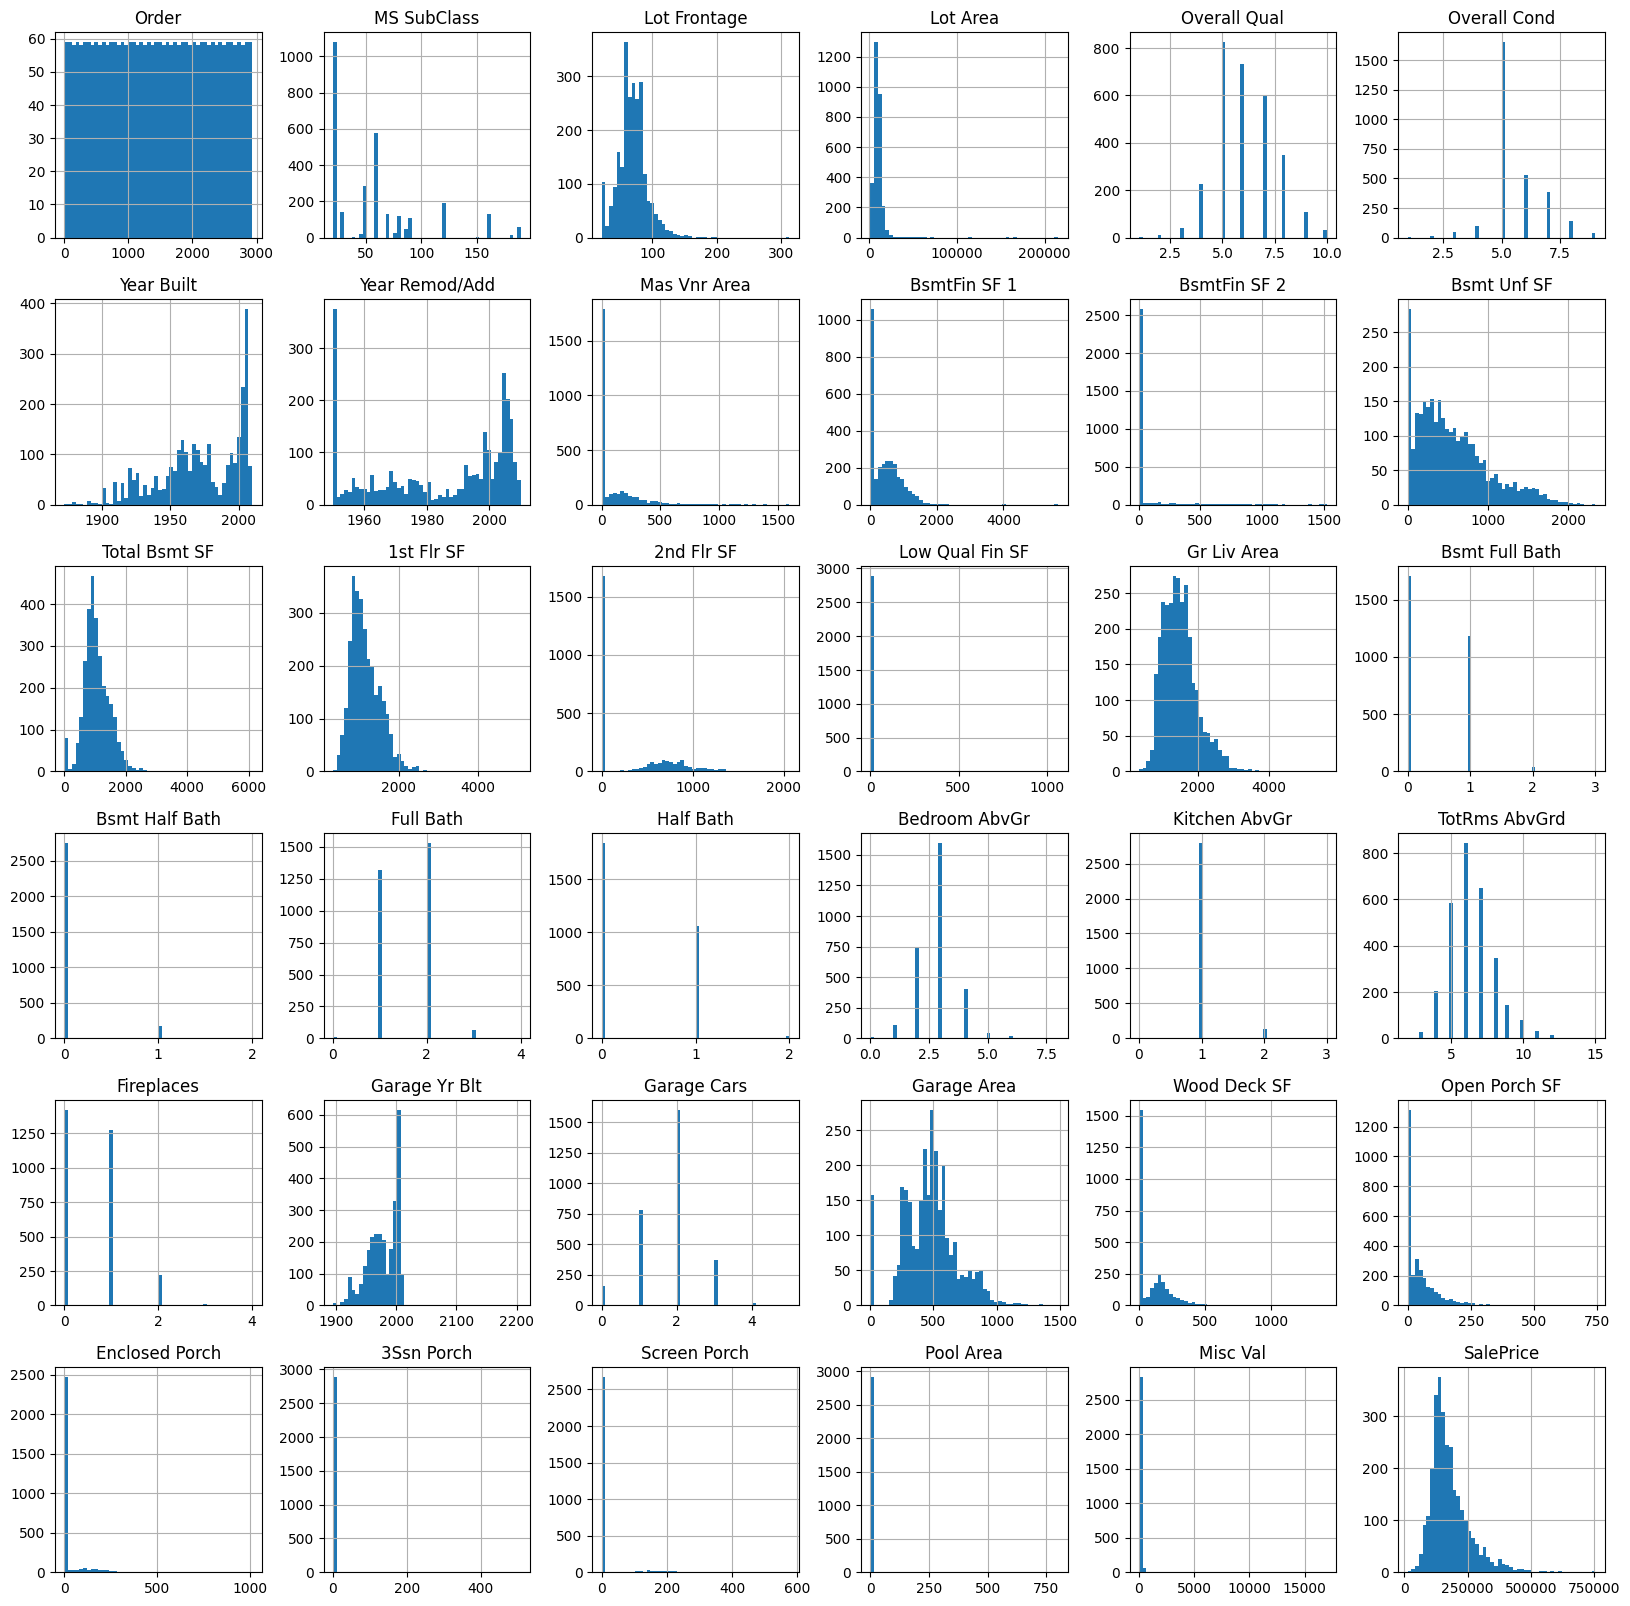

In [56]:
df.hist(figsize=(20,20), bins=50);
df.describe()

In [4]:
#df.select_dtypes(include=[np.number]).hist(figsize=(20, 20))

from sklearn.preprocessing import OneHotEncoder

categorical_cols = df.select_dtypes(include=['object'])

one_hot_encoder = OneHotEncoder(sparse_output=False)

encoded = one_hot_encoder.fit_transform(categorical_cols)

categorical_df = pd.DataFrame(encoded, columns=one_hot_encoder.get_feature_names_out())
pd.set_option('display.max_columns', None)
print(df["MS Zoning"].value_counts())

numerical_cols = df.select_dtypes(include=[np.number])

categorical_with_sale = categorical_df.join(df["SalePrice"])


MS Zoning
RL         2273
RM          462
FV          139
RH           27
C (all)      25
I (all)       2
A (agr)       2
Name: count, dtype: int64


In [17]:
correlations = categorical_with_sale.corr()["SalePrice"].sort_values(key=abs, ascending=False)
pd.set_option("display.max_rows", None)
print(correlations)

SalePrice                 1.000000
Bsmt Qual_Ex              0.593567
Exter Qual_TA            -0.590897
Kitchen Qual_Ex           0.537561
Kitchen Qual_TA          -0.526721
Foundation_PConc          0.520966
Fireplace Qu_nan         -0.481446
Exter Qual_Ex             0.480477
BsmtFin Type 1_GLQ        0.455326
Heating QC_Ex             0.454553
Bsmt Qual_TA             -0.452487
Exter Qual_Gd             0.446489
Neighborhood_NridgHt      0.433299
Garage Finish_Fin         0.424902
Garage Finish_Unf        -0.421876
Mas Vnr Type_nan         -0.394743
Fireplace Qu_Gd           0.371630
Garage Type_Detchd       -0.365074
Bsmt Exposure_Gd          0.355665
Sale Type_New             0.354292
Sale Condition_Partial    0.350122
Foundation_CBlock        -0.349642
Garage Type_Attchd        0.345635
Heating QC_TA            -0.338520
Exterior 1st_VinylSd      0.334416
Exterior 2nd_VinylSd      0.331146
Kitchen Qual_Gd           0.304463
Mas Vnr Type_Stone        0.304290
Lot Shape_Reg       

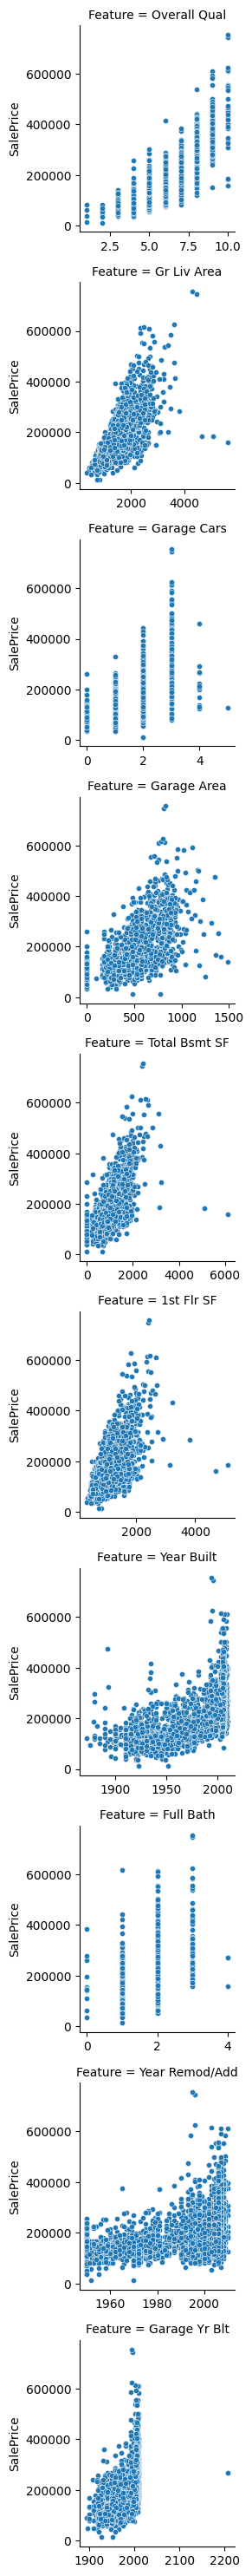

In [ ]:
corr = df.select_dtypes(include=[np.number]).corr()

att = ["Overall Qual",
"Gr Liv Area",
"Garage Cars",
"Garage Area",
"Total Bsmt SF",
"1st Flr SF",
"Year Built",
"Full Bath",
"Year Remod/Add",
"Garage Yr Blt"]

att_all = corr.columns


df_melt = df.melt(id_vars='SalePrice', value_vars=att,
                          var_name='Feature', value_name='Value')

g = sns.FacetGrid(df_melt, col='Feature', col_wrap=1, height=3, sharex=False, sharey=True)
g.map_dataframe(sns.scatterplot, x='Value', y='SalePrice', s=20)
g.set_axis_labels("", "SalePrice")
plt.show()

             Garage Cars  Garage Area
Garage Cars     1.000000     0.889676
Garage Area     0.889676     1.000000


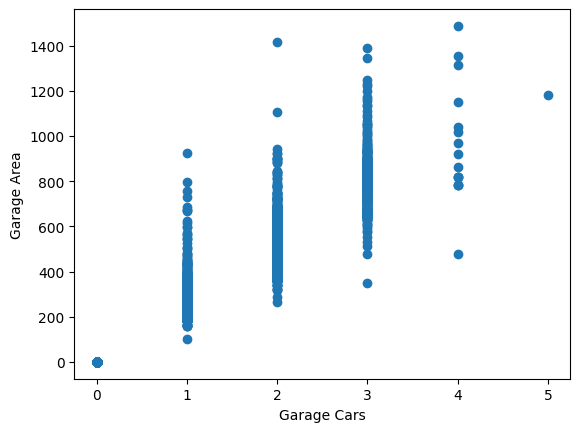

In [14]:
plt.scatter(x='Garage Cars', y='Garage Area', data=df)
plt.xlabel('Garage Cars')
plt.ylabel('Garage Area')

corrmatrix = df[['Garage Cars', 'Garage Area']].corr()
print(corrmatrix)

BsmtFin SF 2       0.005891
Order             -0.031408
3Ssn Porch         0.032225
Bsmt Half Bath    -0.035835
Low Qual Fin SF   -0.037660
Pool Area          0.068403
MS SubClass       -0.085092
Overall Cond      -0.101697
Screen Porch       0.112151
Kitchen AbvGr     -0.119814
Enclosed Porch    -0.128787
Bedroom AbvGr      0.143913
Bsmt Unf SF        0.182855
Lot Area           0.266549
2nd Flr SF         0.269373
Bsmt Full Bath     0.276050
Open Porch SF      0.312951
Wood Deck SF       0.327143
Lot Frontage       0.357318
BsmtFin SF 1       0.432914
Fireplaces         0.474558
TotRms AbvGrd      0.495474
Mas Vnr Area       0.508285
Garage Yr Blt      0.526965
Year Remod/Add     0.532974
Year Built         0.558426
TotalBath          0.580715
1st Flr SF         0.621676
Total Bsmt SF      0.632280
Garage Area        0.640401
Garage Cars        0.647877
Gr Liv Area        0.706780
Overall Qual       0.799262
SalePrice          1.000000
Name: SalePrice, dtype: float64


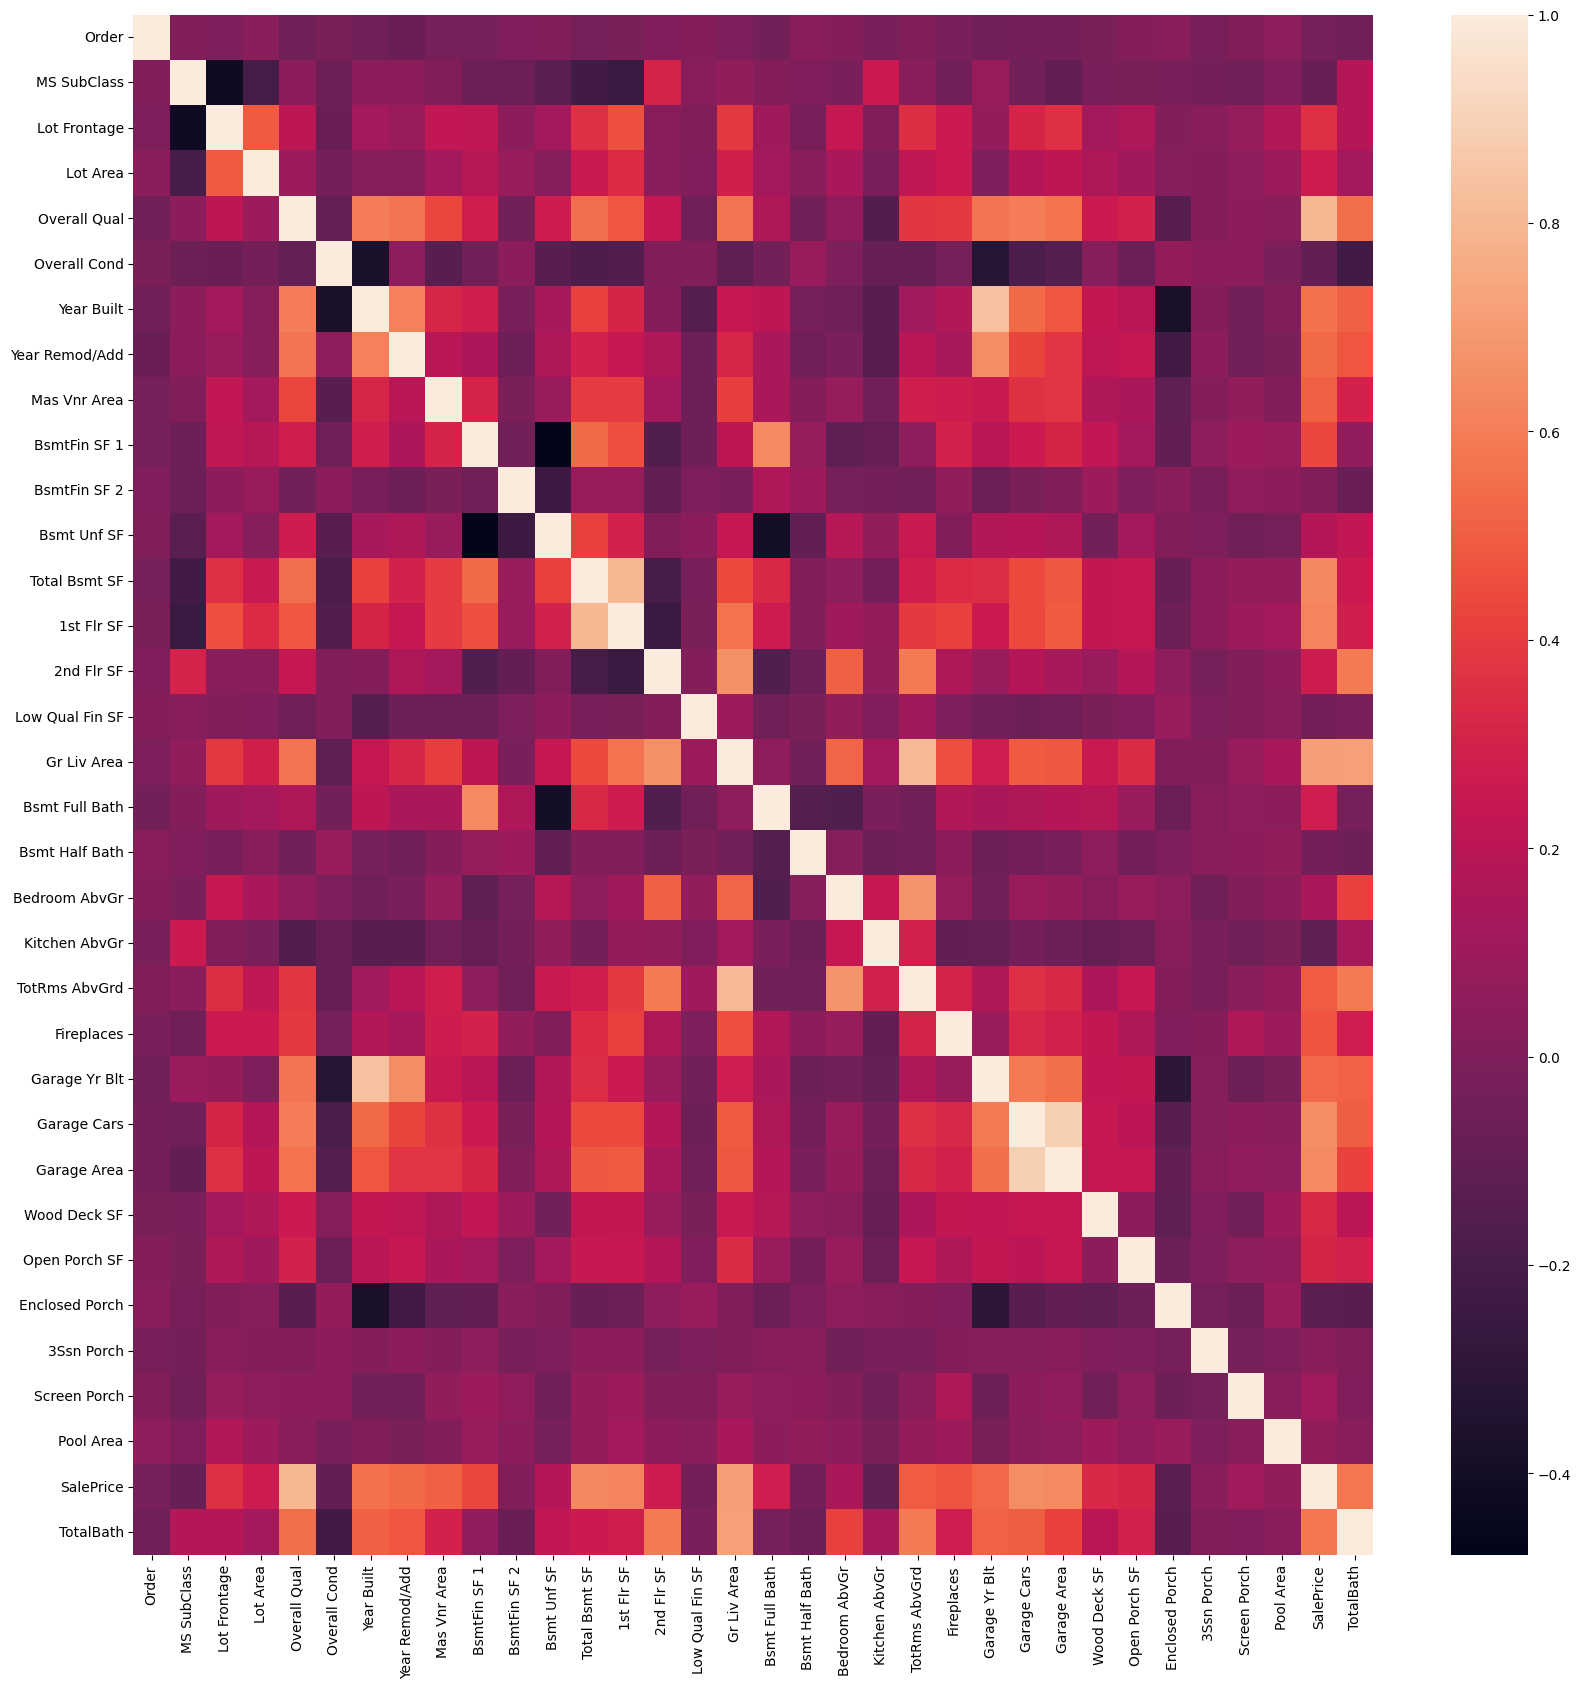

In [69]:
numerical_features = df.select_dtypes(np.number)

corr = numerical_features.corr()

fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr, ax=ax)

print(corr["SalePrice"].sort_values(key=abs))
